# Structure

For a semantic meaning c and a set of features x, we have:

$$P(c|x)=\frac{P(x|c)*P(c)}{P(x)}$$

but the denominator P(x) is the same for all classes and thus can be removed leaving:
$$P(c|x)=P(x|c)*P(c)$$

$$P(c_1|x,C)=P(x|c_1,C)*P(c_1|C)$$
1) P(c): is the prior probability of a class, in our case we calculate all cases of male.n... independent of the word, and we calculate how many times male.n is male.n.01 or male.n.02, and normalize this value.

2) We will need to decide exactly what features ('x') we want to use, maybe this will require looking a bit into some papers. 

3) Sliding context window. 
  - set a value for context window (start with 2 or 3)
  - deal with context window out of bounds: pad with nonsense words before first word
  
4) P(x|c_1,C)=P(x|c_1) so same as the original formula.
    For this we extract all the decided features in the context window and assign them to the correct class, and keep a count on their frequency. 
    
5) Add smoothing.
  


In [2]:
# This is just a visual thing, I don't like how Jupyter usually displays things
from IPython.display import display, HTML

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

# Data processing

In [3]:
import pandas as pd

In [4]:
df = pd.DataFrame(columns = ["sentence", "word", "sym", "sem", "sns"])

def read_input():
    examples = []
    id = ''
    with open("data.txt") as f:
        for line in f.readlines():
            if '#' in line:
                id = line.strip().split('=')[1]
            elif len(line) > 1:
                sp = line.strip().split('\t')
                df.loc[len(df)] = [id, sp[0], sp[1], sp[2], sp[4]]
    return df

dat = read_input()
display(dat)

,sentence,word,sym,sem,sns
0,p00/d2862,Tom,tom,PER,male.n.02
1,p00/d2862,was,be,PST,O
2,p00/d2862,carrying,carry,EXG,carry.v.01
3,p00/d2862,a,a,DIS,O
4,p00/d2862,bucket,bucket,CON,bucket.n.01
...,...,...,...,...,...
5418,p10/d2454,.,.,NIL,O
5419,p10/d2335,Tom,tom,PER,male.n.02
5420,p10/d2335,was,be,PST,O
5421,p10/d2335,unarmed,unarmed,IST,unarmed.a.01


In [5]:
# Number of words that have a meaningful sense: 2525.
# This should also be the number of windows for all sizes! 
print(len(dat[dat['sns'] != 'O']))

2525


# Count occurrences of each word, respective to each word sense
### Make dataframe of all unique words and their total counts (not respective to sense)

In [3]:
unique_words = dat['word'].value_counts().rename_axis('unique_word').reset_index(name='total_count')
display(unique_words)

,unique_word,total_count
0,.,776
1,I,177
2,the,176
3,Tom,173
4,is,168
...,...,...
1557,illiterate,1
1558,mashed,1
1559,Our,1
1560,tried,1


### Per unique word, get all unique senses it's used with and their counts.  Store in another dataframe. Also, store all ambiguous words in another dataframe. 

In [13]:
ambiguous_words = pd.DataFrame(columns = ['word', 'sense', 'count', 'normalize'])
word_df = pd.DataFrame(columns = ['word', 'sense', 'count', 'normalize' ])

# Loop over unique words and get their unique senses
for word in unique_words['unique_word']:
    ambiguous = False
    word_dis = dat[dat['word'] == word]
    sense_counts = word_dis['sns'].value_counts().rename_axis('sense').reset_index(name='counts')
    norm= word_dis['sns'].value_counts(normalize=True).rename_axis('sense').reset_index(name='normalize')
    #display(sense_counts)
    #display(norm)
    new=pd.merge(sense_counts, norm, on=['sense'], how='left')
    #display(norm)
    if len(sense_counts) > 1:
        ambiguous = True
    
    # Store in dataframe
    for i, row in new.iterrows():
        word_df.loc[len(word_df)] = [word, row['sense'], row['counts'], row['normalize']]
        if ambiguous:
            ambiguous_words.loc[len(ambiguous_words)] = [word, row['sense'], row['counts'], row['normalize']]
            
display(word_df)
display(ambiguous_words)

,word,sense,count,normalize
0,.,O,776,1.00000
1,I,O,177,1.00000
2,the,O,176,1.00000
3,Tom,male.n.02,172,0.99422
4,Tom,O,1,0.00578
...,...,...,...,...
1771,illiterate,illiterate.a.01,1,1.00000
1772,mashed,mash.v.03,1,1.00000
1773,Our,O,1,1.00000
1774,tried,try.v.01,1,1.00000


,word,sense,count,normalize
0,Tom,male.n.02,172,0.994220
1,Tom,O,1,0.005780
2,is,O,125,0.744048
3,is,be.v.02,19,0.113095
4,is,be.v.01,12,0.071429
...,...,...,...,...
366,always,O,1,0.500000
367,part,part.n.05,1,0.500000
368,part,O,1,0.500000
369,Nobody,person.n.01,1,0.500000


In [15]:
# Some examples
display(word_df[word_df['word']=='Tom'])
display(word_df[word_df['word']=='is'])
display(word_df[word_df['sense']=='be.v.01'])

,word,sense,count,normalize
3,Tom,male.n.02,172,0.99422
4,Tom,O,1,0.00578


,word,sense,count,normalize
5,is,O,125,0.744048
6,is,be.v.02,19,0.113095
7,is,be.v.01,12,0.071429
8,is,be.v.03,4,0.023810
9,is,be.v.08,4,0.023810
10,is,be.v.06,3,0.017857
11,is,be.v.13,1,0.005952


,word,sense,count,normalize
7,is,be.v.01,12,0.071429
21,was,be.v.01,1,0.016393
27,'s,be.v.01,2,0.035088


## Different P(c) calculation independent of the word itself, but only dependent on the sns tag 

In [6]:
trial = pd.DataFrame(columns = ['sense' ])
result = pd.DataFrame(columns = ['sense',   'normalize'])

# Loop over unique general sns (without disabiguation so witout 01,02,03)

trials=dat['sns'].str.rstrip('1234567890').unique()

for trial in trials:
    word_dis = dat[dat['sns'].str.startswith(trial)]
    
    #print(word_dis)
    
    sense_counts = word_dis['sns'].value_counts().rename_axis('sense').reset_index(name='counts')
    norm = word_dis['sns'].value_counts(normalize=True).rename_axis('sense').reset_index(name='normalize')
    
    new = pd.merge(sense_counts, norm, on=['sense'], how='left')
    
    result = result.append(new)
    

display(result)

,sense,normalize,counts
0,male.n.02,0.997093,343.0
1,male.n.01,0.002907,1.0
0,O,1.000000,2898.0
0,carry.v.01,1.000000,1.0
0,bucket.n.01,1.000000,2.0
...,...,...,...
0,courteous.a.01,1.000000,1.0
0,wind.n.01,1.000000,1.0
0,blow.v.02,1.000000,1.0
0,shirt.n.01,1.000000,1.0


In [7]:
display(result[result['sense']=='be.v.01'])
display(result[result['sense']=='male.n.02'])

,sense,normalize,counts
2,be.v.01,0.182927,15.0


,sense,normalize,counts
0,male.n.02,0.997093,343.0


# Calculating sentence lenght distribution, mean,..

In [8]:
# To choose viable window sizes, find some statistics on sentence length
# NOTE: so far, this is including punctuation! 
lengths = dat['sentence'].value_counts().rename_axis('sentence').reset_index(name='length')
display(lengths)
display(lengths['length'].describe())

,sentence,length
0,p30/d0706,32
1,p00/d1824,14
2,p30/d3369,14
3,p20/d2455,14
4,p20/d2434,14
...,...,...
880,p00/d1164,2
881,p20/d2779,2
882,p00/d2536,2
883,p20/d1782,2


count    885.000000
mean       6.127684
std        2.191244
min        2.000000
25%        5.000000
50%        6.000000
75%        7.000000
max       32.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Frequency'>

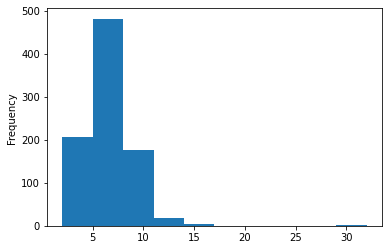

In [9]:
display(lengths['length'].plot.hist())

# Sliding context window

In [10]:
sl=dat[dat["sentence"]==' p00/d2862']

In [11]:
count=0
for item in dat['sentence'].unique():
    
    
    print(item)
    sent=dat[dat['sentence']==item]
    
    for item_in_sent in sent:
        print
    
    count+=1
    display(sent)
    
    if count==3:
        break

 p00/d2862


,sentence,word,sym,sem,sns
0,p00/d2862,Tom,tom,PER,male.n.02
1,p00/d2862,was,be,PST,O
2,p00/d2862,carrying,carry,EXG,carry.v.01
3,p00/d2862,a,a,DIS,O
4,p00/d2862,bucket,bucket,CON,bucket.n.01
5,p00/d2862,of,of,REL,O
6,p00/d2862,water,water,CON,water.n.06
7,p00/d2862,.,.,NIL,O


 p30/d2583


,sentence,word,sym,sem,sns
8,p30/d2583,I,speaker,PRO,O
9,p30/d2583,have,have,NOW,O
10,p30/d2583,n't,not,NOT,O
11,p30/d2583,touched,touch,EXT,touch.v.01
12,p30/d2583,anything,entity,DIS,entity.n.01
13,p30/d2583,.,.,NIL,O


 p30/d0794


,sentence,word,sym,sem,sns
14,p30/d0794,Mr,mr,ROL,mr.n.01
15,p30/d0794,Smith,smith,PER,male.n.02
16,p30/d0794,teaches,teach,ENS,teach.v.01
17,p30/d0794,me,speaker,PRO,O
18,p30/d0794,English,english,CON,english.n.01
19,p30/d0794,.,.,NIL,O


In [8]:
# Data sets created by window.py
win_3 = pd.read_csv("context_size_3.csv", index_col=0)
display(win_3)

,sentence,word,sense,context,sym_context,sem_context,sns_context
0,p00/d2862,Tom,male.n.02,"['Tom', 'was']","['tom', 'be']","['PER', 'PST']","['male.n.02', 'O']"
1,p00/d2862,carrying,carry.v.01,"['was', 'carrying', 'a']","['be', 'carry', 'a']","['PST', 'EXG', 'DIS']","['O', 'carry.v.01', 'O']"
2,p00/d2862,bucket,bucket.n.01,"['a', 'bucket', 'of']","['a', 'bucket', 'of']","['DIS', 'CON', 'REL']","['O', 'bucket.n.01', 'O']"
3,p00/d2862,water,water.n.06,"['of', 'water', '.']","['of', 'water', '.']","['REL', 'CON', 'NIL']","['O', 'water.n.06', 'O']"
4,p30/d2583,touched,touch.v.01,"[""n't"", 'touched', 'anything']","['not', 'touch', 'entity']","['NOT', 'EXT', 'DIS']","['O', 'touch.v.01', 'entity.n.01']"
...,...,...,...,...,...,...,...
2520,p10/d2454,wore,wear.v.01,"['Tom', 'wore', 'a']","['tom', 'wear', 'a']","['PER', 'EPS', 'DIS']","['male.n.02', 'wear.v.01', 'O']"
2521,p10/d2454,Hawaiian,island.n.01,"['a', 'Hawaiian', 'shirt']","['a', 'hawaii', 'shirt']","['DIS', 'GPO', 'CON']","['O', 'island.n.01', 'shirt.n.01']"
2522,p10/d2454,shirt,shirt.n.01,"['Hawaiian', 'shirt', '.']","['hawaii', 'shirt', '.']","['GPO', 'CON', 'NIL']","['island.n.01', 'shirt.n.01', 'O']"
2523,p10/d2335,Tom,male.n.02,"['Tom', 'was']","['tom', 'be']","['PER', 'PST']","['male.n.02', 'O']"


In [11]:
print("Column", "Unique values")
for col in win_3.columns:
    print(col, len(win_3[col].unique()))

Column Unique values
sentence 881
word 1365
sense 1206
context 2331
sym_context 2273
sem_context 857
sns_context 2006
